Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________
Found 8 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Train samples: 8
Vali

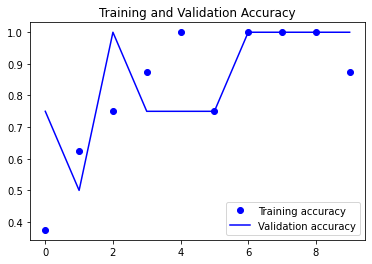

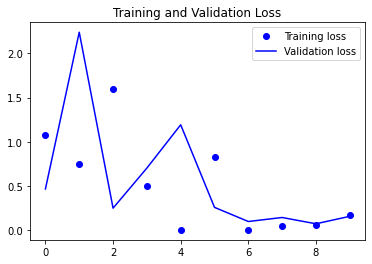

In [60]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1. Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# 2. Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 4. Prepare data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'images/train'
val_dir = 'images/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Debug: Check generator output
print("Train samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)

# 5. Fix steps to handle small datasets
steps_per_epoch = max(1, train_generator.samples // 32)
validation_steps = max(1, validation_generator.samples // 32)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# 6. Train
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# 7. Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 8. Save
model.save('dog_vs_cat_vgg16.h5')

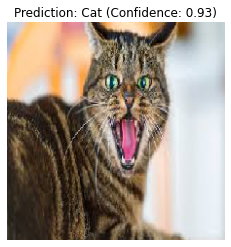

Predicted: Cat with confidence 0.93


In [63]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = '/home/suhas/Downloads/wo.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Load the model and predict
model = tf.keras.models.load_model('dog_vs_cat_vgg16.h5')
prediction = model.predict(img_array)
label = 'Dog' if prediction[0] > 0.5 else 'Cat'
confidence = prediction[0][0] if prediction[0] > 0.5 else 1 - prediction[0][0]  # Confidence score

# Display the image with prediction
plt.imshow(img)  # Show the original image
plt.title(f'Prediction: {label} (Confidence: {confidence:.2f})')  # Add title with label and confidence
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

# Print the prediction too (optional)
print(f'Predicted: {label} with confidence {confidence:.2f}')